# Q8 Analyze HRV

Dig into the Rhinovirus results in the Q8 sequencing run.

In prior RespiCoV analyses I've relied on hits caching to enable fast analysis. But in Q8 I have a ton more data (28 Gb uncompressed, 22M reads) using a variety of different primers, as well as a lot of samples using only Rhinovirus primers. So rather than use hits caching, let's just split out the entire set of Rhinovirus hits and operate on that. 

This looks over all Q8a/b sequencing reads for the HRV 5' UTR region targetted by the RespiCoV Enterovirus primer pair. Most experiments actually used the HRVKa5 primer set, but they different from ENT rc only in the reverse primer extending 2 bases further beyond the amplicon, so we can just ignore that.

Note that these samples also include a full-genome HRV sequence which we want to exclude.
Reads were basecalled and demuxed with Dorado 0.7.3, using the hac@v5.0.0 model and with barcodes and adapters trimmed.
Reads have not yet been filtered for quality, we do that here.

## Setup

In [25]:
from Bio import Align
import matplotlib_inline.backend_inline
import os
import pandas as pd
import RCUtils
import random
import numpy as np

%load_ext autoreload
%autoreload 1
%aimport RCUtils

# Be deterministic
random.seed(42)

fastQDir = "../Q8/reads-hac/"

pd.options.display.max_rows = 50
pd.options.display.min_rows = 25

# Get the Rhinovirus primer pair.
rcPrimers = RCUtils.readPrimers("RespiCovPrimers.fasta")
hrvPrimers = [p for p in rcPrimers if p.description == "Rhinovirus/Enterovirus 1" or p.description == "Rhinovirus/Enterovirus 3"]
print("Rhinovirus primers:", [str(p.seq) for p in hrvPrimers])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Rhinovirus primers: ['CAAGCACTTCTGTTTCCCCGG', 'AACACGGACACCCAAAGTAGT']


## Utilities

In [26]:
import math

# Get the hits across all files but allow a limit on the number of reads per file.
# Many files have over a million reads.
def getAllPrimerHits(maxReadsPerFile = 0, progress = False, skipReads = 0):
    for file in sorted(filter(lambda f: f.endswith(".fastq.gz"), os.listdir(fastQDir))):
        # Skip the 3rd sequencing run results because those samples were SC2 only
        if file.startswith("Q8c-"):
            continue
    
        for (read, hit) in getPrimerHits(file, maxReadsPerFile, progress, skipReads):
            yield (file, read, hit)

def getPrimerHits(file, maxReadsPerFile = 0, progress = False, skipReads = 0, matchThreshold = RCUtils.MATCH_THRESHOLD):
    fastQPath = os.path.join(fastQDir, file)
    if progress:
        print("Processing ", os.path.basename(fastQPath), end="")
    reads = 0
    hitReads = 0
    for read in RCUtils.readFastQ(fastQPath):
        reads += 1
        if reads <= skipReads:
            continue
        hits = RCUtils.computePrimerHits(read, hrvPrimers, matchThreshold=matchThreshold)
        if hits:
            hitReads += 1
        if maxReadsPerFile and reads >= maxReadsPerFile:
            break
        yield (read, hits)
    if progress:
        print(" %d reads, %d with hits (%d%%)" % (reads, hitReads, hitReads * 100 / reads))

def overallPhredScore(phred_scores):
    # Phred scores represent the probability of error, eg. with 10 being 1 in 10, 20 being 1 in 100, etc.
    total_error_prob = 1 - math.prod(1 - 10 ** (-q / 10) for q in phred_scores)
    if total_error_prob == 0:
        return float('inf')
    return -10 * math.log10(total_error_prob)

def printAlignmentWithQuality(alignment, read):
    quality_scores = read.letter_annotations["phred_quality"]
    
    # Initialize strings for the aligned target, query, alignment string, and query quality scores
    aligned_target = ""
    aligned_query = ""
    alignment_string = ""
    aligned_target_quality = ""
    
    # Use indices to determine where gaps are and construct the alignment, target, query, and quality strings

    for t_index, q_index in zip(*alignment.indices):
        aligned_target += alignment.target[t_index] if t_index != -1 else "-"
        aligned_query += alignment.query[q_index] if q_index != -1 else "-"
        alignment_string += "|" if t_index != -1 and q_index != -1 and alignment.target[t_index] == alignment.query[q_index] else "."
        if t_index == -1:
            aligned_target_quality += "-"
        else:
            ns = quality_scores[t_index] // 4
            aligned_target_quality += str(ns) if ns < 10 else "9"

    print("target quality     ", aligned_target_quality)
    print("target             ", aligned_target)
    print("                   ", alignment_string)
    print("query              ", aligned_query)
    qstart = alignment.indices[1,0]
    qend = alignment.indices[1,-1]
    print("average quality: ", int(np.mean(quality_scores[qstart:qend])))
    print("total quality: ", int(overallPhredScore(quality_scores[qstart:qend])))
    print("")


# Examine the distribution of primer hit scores at the start

Perhaps we could make things a lot faster by using only exact matches?
This looks only at the start of one barcode, it will vary later in the read sequence.
The score distribution goes up at thresholds below around 0.8, and really spikes around 0.6. So 0.8 still seems like a good cutoff.

In [5]:
from Bio import Align

for (read, hits) in getPrimerHits("Q8a-hac_barcode01.fastq.gz", maxReadsPerFile=5, matchThreshold = 0.65):
    print ("%s %d" % (read.id, len(read)))
    for hit in hits:
        print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))
        aligner = Align.PairwiseAligner(mode='local', match_score=1, mismatch_score=0, gap_score=-1)
        print(aligner.align(read.seq, hit.primer.seq)[0])


bbe4b3b4-92cc-4ded-8674-52697668e304 387
   0.95 0-22: Rhinovirus/Enterovirus 3 (21)
target            0 AACACGGACACCCAAAGTCAGT 22
                  0 ||||||||||||||||||-||| 22
query             0 AACACGGACACCCAAAGT-AGT 21

   0.90 368-387: Rhinovirus/Enterovirus 1 (21 rev)
target          325 CGATCTCTGCTGTTTTTGCCCTG 348
                  0 |.|.|.||.||||||.--|||.|  23
query             0 CAAGCACTTCTGTTTC--CCCGG  21

21b616e1-0b07-4359-bbe1-b46ea58bbffa 389
   1.00 0-21: Rhinovirus/Enterovirus 3 (21)
target            0 AACACGGACACCCAAAGTAGT 21
                  0 ||||||||||||||||||||| 21
query             0 AACACGGACACCCAAAGTAGT 21

   1.00 367-388: Rhinovirus/Enterovirus 1 (21 rev)
target          324 CGATCTCAACTGTTTTCGCCCTG 347
                  0 |.|.|.|..||||||-|-|||.|  23
query             0 CAAGCACTTCTGTTT-C-CCCGG  21

6a4010fc-051b-4b03-bed5-2936c168d7de 380
   0.67 0-18: Rhinovirus/Enterovirus 1 (21)
target            0 CAAGCGCTTCTG---CCCCGG 18
                  0 |||||.||||||-

In [27]:
from Bio import Align

#RCUtils.primer_hits_to_print = 3

for (read, hits) in getPrimerHits("Q8a-hac_barcode01.fastq.gz", maxReadsPerFile=4, matchThreshold=0.65):
    print("%s %d" % (read.id, len(read)))

    for hit in hits:
        print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))

        alignment = RCUtils.getPrimerAligner().align(read.seq, hit.primer.rcSeq if hit.rev else hit.primer.seq)[0]
        RCUtils.extendAlignment(alignment)
        print("Score: ", alignment.score, " Len:", len(alignment.query))
        printAlignmentWithQuality(alignment, read)


bbe4b3b4-92cc-4ded-8674-52697668e304 387
   0.95 0-22: Rhinovirus/Enterovirus 3 (21)
Score:  20.0  Len: 21
target quality      7766666667777788882112
target              AACACGGACACCCAAAGTCAGT
                    ||||||||||||||||||.|||
query               AACACGGACACCCAAAGT-AGT
average quality:  27
total quality:  4

   0.90 368-387: Rhinovirus/Enterovirus 1 (21 rev)
Score:  19.0  Len: 21
target quality      6656676777778866666--
target              CCGGGGAAACAGAAGTGCT--
                    |||||||||||||||||||..
query               CCGGGGAAACAGAAGTGCTTG
average quality:  27
total quality:  4

21b616e1-0b07-4359-bbe1-b46ea58bbffa 389
   1.00 0-21: Rhinovirus/Enterovirus 3 (21)
Score:  21.0  Len: 21
target quality      667444467888899998776
target              AACACGGACACCCAAAGTAGT
                    |||||||||||||||||||||
query               AACACGGACACCCAAAGTAGT
average quality:  29
total quality:  11

   1.00 367-388: Rhinovirus/Enterovirus 1 (21 rev)
Score:  21.0  Len: 21
target qual

4320 of 10523 (41%) of primer hits are a perfect match


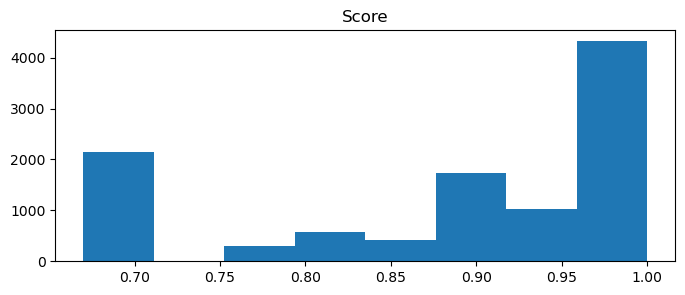

In [71]:
mrs = []
perfect = 0
for hits in getPrimerHits("Q8a-hac_barcode01.fastq.gz", maxReadsPerFile=10000, matchThreshold = 0.65):
    for hit in hits:
        mrs.append(hit.mr)
        if hit.mr == 1.0:
            perfect += 1

print("%d of %d (%d%%) of primer hits are a perfect match" % (perfect, len(mrs), 100*perfect/len(mrs)))
pd.DataFrame({'Score': mrs}).hist(figsize=(8,3), bins=8, grid=False);

## Get an idea for the distribution of reads with hits

Barcodes 1 to 7 are our main HRV samples.
Barcodes 19-21 are RespiCoV and so are expected to have some HRV.
Barcode 18 is the HRV-C1 full genome. TODO: why so few hits?

Overall this looks good, we mostly have hits where we expect them.

TODO: Filter out reads with the first HRV-C1 primer, why don't I see any in NB18?

In [48]:
hitCount = 0
for (file, hits) in getAllPrimerHits(maxReadsPerFile=1000, progress=True):
    hitCount += len(hits)

print("Total hits:", hitCount)

# Make sure there's not some sort of big positional / time bias
for (file, hits) in getAllPrimerHits(maxReadsPerFile=1000, progress=True, skipReads=10000):
    hitCount += len(hits)


Processing  Q8a-hac_barcode01.fastq.gz 1000 reads, 796 with hits (79%)
Processing  Q8a-hac_barcode02.fastq.gz 1000 reads, 753 with hits (75%)
Processing  Q8a-hac_barcode03.fastq.gz 1000 reads, 788 with hits (78%)
Processing  Q8a-hac_barcode04.fastq.gz 1000 reads, 741 with hits (74%)
Processing  Q8a-hac_barcode05.fastq.gz 1000 reads, 765 with hits (76%)
Processing  Q8a-hac_barcode06.fastq.gz 1000 reads, 747 with hits (74%)
Processing  Q8a-hac_barcode07.fastq.gz 1000 reads, 834 with hits (83%)
Processing  Q8a-hac_barcode11.fastq.gz 1000 reads, 8 with hits (0%)
Processing  Q8a-hac_barcode12.fastq.gz 1000 reads, 357 with hits (35%)
Processing  Q8a-hac_barcode13.fastq.gz 1000 reads, 5 with hits (0%)
Processing  Q8a-hac_barcode14.fastq.gz 1000 reads, 104 with hits (10%)
Processing  Q8a-hac_barcode15.fastq.gz 1000 reads, 1 with hits (0%)
Processing  Q8a-hac_barcode16.fastq.gz 1000 reads, 68 with hits (6%)
Processing  Q8a-hac_barcode17.fastq.gz 1000 reads, 8 with hits (0%)
Processing  Q8a-hac_